# RIC and RBDS 3D running study: an example of collaborative and reproducible research
> Reginaldo K Fukuchi$^{1,2}$, Reed Ferber$^{2}$ 
> $^{1}$Biomedical Engineering, Federal University of ABC, Brazil
> $^{2}$Faculty of Kinesiology, University of Calgary, Canada


This notebook presents the comparison of 3D running kinematics between runners from Brazil and Canada. The data were collected using similar experimental procedures and by the same experimenter (RKF) in both centres. 

The notebook uses the raw marker trajectories from standing calibration and running trials; and outputs 3D joint angles of the hip, knee and ankle joints during the gait cycle. 

All the analyses were performed using computer programs written in Python and they are provided along with the markers data and the notebook itself. Therefore, the consistency of the results presented here can be assessed by any user interested in reproducing this reseach.

The data are from published data sets (Fukuchi et al. (2017) and Ferber et al. (in preparation).

<p style="text-align: right;">A <a href="https://jupyter.org/">Jupyter Notebook</a></p>

In [34]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [35]:
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/MyDrive/Github/UFABC_UofC_datasets"
  
  # Create drive_root if it doesn't exist
  create_drive_root = False
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: Changing directory to  /content/gdrive/MyDrive/Github/UFABC_UofC_datasets
/content/gdrive/MyDrive/Github/UFABC_UofC_datasets


In [36]:
!git init

Reinitialized existing Git repository in /content/gdrive/MyDrive/Github/UFABC_UofC_datasets/.git/


In [ ]:
# Prepare environment
import os
import scipy.io as spio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Import data
pathname = os.path.join(drive_root,'data')

## Choose RIC or RBDS data set

In [ ]:
db_name = 'RBDS'

In [ ]:
if db_name=='RIC':
    fname_out_S = os.path.join(pathname, 'RIC_static.csv')
    fname_out_R = os.path.join(pathname, 'RIC_run.csv')
else:
    fname_out_S = os.path.join(pathname, 'RBDS_static.csv')
    fname_out_R = os.path.join(pathname, 'RBDS_run.csv')
    
print('Static trial filename: ' + fname_out_S)
print('Running trial filename: ' + fname_out_R)

Static trial filename: /content/gdrive/MyDrive/Github/UFABC_UofC_datasets/data/RBDS_static.csv
Running trial filename: /content/gdrive/MyDrive/Github/UFABC_UofC_datasets/data/RBDS_run.csv


In [ ]:
df_s = pd.read_csv(fname_out_S, delimiter=',', index_col='Time')

In [ ]:
df_s.head()

,LMAL_X,LMAL_Y,LMAL_Z,LMAM_X,LMAM_Y,LMAM_Z,LASI_X,LASI_Y,LASI_Z,LGTR_X,...,RTBM_Z,RTTL_X,RTTL_Y,RTTL_Z,RTTM_X,RTTM_Y,RTTM_Z,RTUB_X,RTUB_Y,RTUB_Z
Time,,,,,,,,,,,,,,,,,,,,,
0.000000,705.062866,108.774330,1050.909424,725.535095,119.272575,1129.002441,876.648743,1067.346436,1126.366577,799.197205,...,1345.514282,725.082825,761.838928,1398.587158,676.568359,760.431702,1347.822632,780.426636,462.710876,1343.646973
0.006711,705.066833,108.766876,1050.910889,725.530396,119.266960,1129.005005,876.686035,1067.344360,1126.387573,799.232788,...,1345.495483,725.089050,761.827515,1398.581421,676.584167,760.432800,1347.808350,780.445190,462.712555,1343.645752
0.013423,705.065430,108.771133,1050.902832,725.532959,119.267067,1129.006104,876.736938,1067.349854,1126.407471,799.294189,...,1345.485840,725.094055,761.832520,1398.583130,676.592529,760.428711,1347.793579,780.457764,462.725372,1343.636353
0.020134,705.067078,108.770615,1050.907104,725.535950,119.267815,1129.002930,876.780396,1067.346436,1126.431274,799.340088,...,1345.468140,725.094055,761.823364,1398.575684,676.612793,760.425476,1347.788452,780.471008,462.721649,1343.632812
0.026846,705.060730,108.771179,1050.905151,725.534241,119.267807,1129.004883,876.821350,1067.347900,1126.442627,799.390625,...,1345.458984,725.103516,761.824829,1398.569946,676.621399,760.423767,1347.771729,780.485840,462.709076,1343.625610


### Calculate hip joint center
* https://c-motion.com/v3dwiki/index.php?title=Coda_Pelvis
* RHJC=(-0.19*ASIS_Distance,-0.3*ASIS_Distance,0.36*ASIS_Distance)

In [ ]:
def hip_jc(RASI, LASI):
  """
  Calculate hip joint centre based on Coda method
  """
  ASIS_distance_S = np.linalg.norm(RASI-LASI, axis=1)
  hjc = np.array([RASI[:,0]-0.19*ASIS_distance_S, RASI[:,1]-0.3*ASIS_distance_S,
                  RASI[:,2]-0.36*ASIS_distance_S]).T
  
  return hjc

In [ ]:
RASI = df_s[['RASI_X','RASI_Y','RASI_Z']].values
LASI = df_s[['LASI_X','LASI_Y','LASI_Z']].values
rhjc_S = hip_jc(RASI, LASI).mean(axis=0)
rhjc_S

array([ 816.67286235,  997.00712237, 1261.0507783 ])

In [ ]:
# Shank reference system
rkjc_S = (df_s[['RKNL_X','RKNL_Y','RKNL_Z']].values.mean(axis=0)+
        df_s[['RKNM_X','RKNM_Y','RKNM_Z']].values.mean(axis=0))/2
rajc_S = (df_s[['RMAL_X','RMAL_Y','RMAL_Z']].values.mean(axis=0)+
        df_s[['RMAM_X','RMAM_Y','RMAM_Z']].values.mean(axis=0))/2

v2 = rkjc_S - rajc_S
v1 = np.cross(v2, df_s[['RMAL_X','RMAL_Y','RMAL_Z']].values.mean(axis=0) - rajc_S)
v3 = np.cross(v1, v2)

print('Versors of the shank:')
v1 = v1/np.linalg.norm(v1)
print('v1 =', v1)
v2 = v2/np.linalg.norm(v2)
print('v2 =', v2)
v3 = v3/np.linalg.norm(v3)
print('v3 =', v3)

bs = np.array([v1, v2, v3])

Versors of the shank:
v1 = [ 0.97670129 -0.03645553  0.21148426]
v2 = [ 0.05076583  0.99674458 -0.06263446]
v3 = [-0.20851241  0.07191133  0.97537241]


In [ ]:
# Thigh reference system
v2t = rhjc_S-rkjc_S
v1t = np.cross(v2t,df_s[['RKNL_X','RKNL_Y','RKNL_Z']].values.mean(axis=0)-rkjc_S)
v3t = np.cross(v2t,v1t)

print('Versors of the thigh:')
v1t = v1t/np.linalg.norm(v1t)
print('v1t =', v1t)
v2t = v2t/np.linalg.norm(v2t)
print('v2t =', v2t)
v3t = v3t/np.linalg.norm(v3t)
print('v3t =', v3t)

bt = np.array([v1t,v2t,v3t])

Versors of the thigh:
v1t = [ 0.98291093 -0.18387985 -0.00861974]
v2t = [ 0.18066167  0.97257537 -0.14648725]
v3t = [-0.0353194  -0.14242666 -0.989175  ]


# Running data

In [ ]:
df_r = pd.read_csv(fname_out_R, delimiter=',', index_col='Time')

In [ ]:
df_r.head()

,LASI_X,LASI_Y,LASI_Z,LHED_X,LHED_Y,LHED_Z,LHEL_X,LHEL_Y,LHEL_Z,LHEP_X,...,RTBL_Z,RTBM_X,RTBM_Y,RTBM_Z,RTTL_X,RTTL_Y,RTTL_Z,RTTM_X,RTTM_Y,RTTM_Z
Time,,,,,,,,,,,,,,,,,,,,,
0.000000,2420.259766,992.218079,963.925171,2248.016602,36.936264,1112.201294,2269.700439,54.548782,1068.700684,2260.437256,...,1220.158203,2340.021729,534.565857,1166.274048,2355.980225,648.041931,1231.687134,2306.586182,637.986877,1182.760010
0.006668,2418.855469,990.269226,964.056519,2224.396729,37.268295,1111.626831,2246.146484,54.657806,1068.011963,2236.888672,...,1221.252930,2352.635742,532.309326,1168.092407,2365.203125,646.438843,1233.347290,2315.817139,634.595154,1184.833984
0.013336,2418.053711,988.938965,964.259094,2200.811035,37.668098,1111.173828,2222.609863,54.926060,1067.611816,2213.396240,...,1222.161255,2366.121582,531.614136,1169.939331,2374.555420,646.219849,1234.858398,2324.990723,632.330994,1187.102295
0.020004,2416.767334,987.159058,965.014771,2177.300537,38.305260,1111.021484,2199.177979,55.535648,1067.508057,2190.177246,...,1222.913574,2379.001953,532.383545,1171.363647,2383.882324,647.272034,1236.181274,2333.870605,631.130493,1189.600342
0.026673,2415.681396,985.919983,965.522888,2153.892822,38.982204,1110.988770,2175.719238,56.226032,1067.396606,2166.902100,...,1223.486572,2391.377197,534.346802,1172.849243,2392.567627,649.902832,1237.175293,2342.278076,631.113098,1192.028198


## Reconstruct anatomical markers using SVD algorithm

In [ ]:
import sys
sys.path.insert(1, os.path.join(drive_root,'functions'))
from svdt import svdt

### The RIC marker protocol does not have RASI and LASI markers in the running trials, so we have to create virtual ones

In [ ]:
RPSIr = df_r[['RPSI_X','RPSI_Y','RPSI_Z']].values
LPSIr = df_r[['LPSI_X','LPSI_Y','LPSI_Z']].values
RHEDr = df_r[['RHED_X','RHED_Y','RHED_Z']].values
if db_name=='RIC':
    # Pelvic segment
    Ap = df_s[['RPSI_X','RPSI_Y','RPSI_Z','LPSI_X','LPSI_Y','LPSI_Z',
               'VSAC_X','VSAC_Y','VSAC_Z']].values.mean(axis=0)
    Bp = df_r[['RPSI_X','RPSI_Y','RPSI_Z','LPSI_X','LPSI_Y','LPSI_Z',
               'VSAC_X','VSAC_Y','VSAC_Z']].values
    
    # Reconstructed markers based on technical clusters
    Rp, Lp, RMSEp = svdt(Ap, Bp)    
    RASIs = df_s[['RASI_X','RASI_Y','RASI_Z']].values.mean(axis=0)
    LASIs = df_s[['LASI_X','LASI_Y','LASI_Z']].values.mean(axis=0)
    RASIr = np.dot(Rp,RASIs)  + Lp
    LASIr = np.dot(Rp,LASIs)  + Lp
    VSACr = df_r[['VSAC_X','VSAC_Y','VSAC_Z']].values
else:
    RASIr = df_r[['RASI_X','RASI_Y','RASI_Z']].values
    LASIr = df_r[['LASI_X','LASI_Y','LASI_Z']].values
    VSACr  = (RPSIr+LPSIr)/2

In [ ]:
# Thigh segment
At = df_s[['RTTL_X','RTTL_Y','RTTL_Z','RTTM_X','RTTM_Y','RTTM_Z',
             'RTBL_X','RTBL_Y','RTBL_Z','RTBM_X','RTBM_Y','RTBM_Z']].values.mean(axis=0)
Bt = df_r[['RTTL_X','RTTL_Y','RTTL_Z','RTTM_X','RTTM_Y','RTTM_Z',
             'RTBL_X','RTBL_Y','RTBL_Z','RTBM_X','RTBM_Y','RTBM_Z']].values
Rt, Lt, RMSEt = svdt(At, Bt)

In [ ]:
# Shank segment
As = df_s[['RSTL_X','RSTL_Y','RSTL_Z','RSTM_X','RSTM_Y','RSTM_Z',
             'RSBL_X','RSBL_Y','RSBL_Z','RSBM_X','RSBM_Y','RSBM_Z']].values.mean(axis=0)
Bs = df_r[['RSTL_X','RSTL_Y','RSTL_Z','RSTM_X','RSTM_Y','RSTM_Z',
             'RSBL_X','RSBL_Y','RSBL_Z','RSBM_X','RSBM_Y','RSBM_Z']].values
Rs, Ls, RMSEs = svdt(As, Bs)

In [ ]:
# Foot segment
Af = df_s[['RHED_X','RHED_Y','RHED_Z','RHEP_X','RHEP_Y','RHEP_Z',
             'RHEL_X','RHEL_Y','RHEL_Z']].values.mean(axis=0)
Bf = df_r[['RHED_X','RHED_Y','RHED_Z','RHEP_X','RHEP_Y','RHEP_Z',
             'RHEL_X','RHEL_Y','RHEL_Z']].values
Rf, Lf, RMSEf = svdt(Af, Bf)

In [ ]:
# knee markers
RKNLs = df_s[['RKNL_X','RKNL_Y','RKNL_Z']].values.mean(axis=0)
RKNMs = df_s[['RKNM_X','RKNM_Y','RKNM_Z']].values.mean(axis=0)
RKNLr = np.empty(shape=(Rt.shape[0],3))
RKNMr = np.empty(shape=(Rt.shape[0],3))
# ankle markers
RMALs = df_s[['RMAL_X','RMAL_Y','RMAL_Z']].values.mean(axis=0)
RMAMs = df_s[['RMAM_X','RMAM_Y','RMAM_Z']].values.mean(axis=0)
RMALr = np.empty(shape=(Rs.shape[0],3))
RMAMr = np.empty(shape=(Rs.shape[0],3))
# foot markers
RMH1s = df_s[['RMH1_X','RMH1_Y','RMH1_Z']].values.mean(axis=0)
RMH5s = df_s[['RMH5_X','RMH5_Y','RMH5_Z']].values.mean(axis=0)
RMH1r = np.empty(shape=(Rs.shape[0],3))
RMH5r = np.empty(shape=(Rs.shape[0],3))
# Reconstructed markers based on technical clusters
RKNLr = np.dot(Rt,RKNLs)  + Lt
RKNMr = np.dot(Rt,RKNMs)  + Lt
RMALr = np.dot(Rs,RMALs)  + Ls
RMAMr = np.dot(Rs,RMAMs)  + Ls
RMH1r = np.dot(Rf,RMH1s)  + Ls
RMH5r = np.dot(Rf,RMH5s)  + Ls
RTOEr = (RMH1r+RMH5r)/2

### Hip, knee and ankle joint centres

In [ ]:
ASIS_distanceR = np.linalg.norm(RASIr-LASIr, axis=1)
rhjc_R = np.array([RASIr[:,0]-0.19*ASIS_distanceR, RASIr[:,1]-0.3*ASIS_distanceR, RASIr[:,2]-0.36*ASIS_distanceR]).T

In [ ]:
rkjc_R = (RKNLr+RKNMr)/2
rajc_R = (RMALr+RMAMr)/2

In [ ]:
def pelvisCS(RASIr, LASIr, VSACr):
    # Pelvic reference system
    midASIS = (RASIr+LASIr)/2
    
    v2p = np.cross(RASIr-VSACr,LASIr-VSACr)
    v3p = RASIr-midASIS
    v1p = np.cross(v2p,v3p)

    v1p = v1p/np.linalg.norm(v1p)
    v2p = v2p/np.linalg.norm(v2p)
    v3p = v3p/np.linalg.norm(v3p)

    bp = np.array([v1p,v2p,v3p])
    
    return bp

In [ ]:
def thighCS(rhjc_R, rkjc_R, RKNLr):
    # Thigh reference system
    v2t = rhjc_R-rkjc_R
    v1t = np.cross(v2t,RKNLr-rkjc_R)
    v3t = np.cross(v1t,v2t)

    v1t = v1t/np.linalg.norm(v1t)
    v2t = v2t/np.linalg.norm(v2t)
    v3t = v3t/np.linalg.norm(v3t)

    bt = np.array([v1t,v2t,v3t])
    
    return bt

In [ ]:
def shankCS(rkjc_R, rajc_R, RMALr):
    # Shank reference system
    v2s = rkjc_R-rajc_R
    v1s = np.cross(v2s,RMALr-rajc_R)
    v3s = np.cross(v1s,v2s)

    v1s = v1s/np.linalg.norm(v1s)
    v2s = v2s/np.linalg.norm(v2s)
    v3s = v3s/np.linalg.norm(v3s)

    bs = np.array([v1s,v2s,v3s])
    
    return bs

In [ ]:
def footCS(RHEDr, RMH1r, RMH5r, RTOEr):
    # Foot reference system
    v2f = np.cross(RMH1r-RHEDr, RMH5r-RHEDr)
    v3f = np.cross(RTOEr-RHEDr, v2f)
    v1f = np.cross(v2f, v3f)
    
    v1f = v1f/np.linalg.norm(v1f)
    v2f = v2f/np.linalg.norm(v2f)
    v3f = v3f/np.linalg.norm(v3f)
    
    bf = np.array([v1f,v2f,v3f])
    
    return bf

## Gait events (TD and TO)
These gait events were detected in another NB (RIC_RBDS_gait_events_detection.ipynb) using the method of Zeni.

In [ ]:
LAB = np.array([[1,0,0],[0,1,0],[0,0,1]])

In [ ]:
def td_detect(LAB, RHEDr, RTOEr, bp):
  """
  Detect gait events using the method described by Zeni et al. ()
  """
  import sys
  sys.path.insert(1, os.path.join(drive_root,'functions'))
  from svdt import svdt
  from detecta import detect_peaks

  # Global to local transformation to obtain rotation and translation matrix
  Rp, Lp, RMSEp = svdt(LAB, bp)

  # Express the RTOE and RHEEL markers in the pelvis segment
  RHEDr_pelvis = np.empty(shape=RHEDr.shape)
  RTOEr_pelvis = np.empty(shape=RTOEr.shape)
  for ix in range(RHEDr.shape[0]):
    RHEDr_pelvis[ix,:] = np.dot(Rp[ix,:,:],RHEDr[ix,:]) + Lp[ix,:]
    RTOEr_pelvis[ix,:] = np.dot(Rp[ix,:,:],RTOEr[ix,:]) + Lp[ix,:]

  # Find touch-down time stamps
  iTD = detect_peaks(RHEDr_pelvis[:,0], mph=None, mpd=70, valley=False, show=False)

  return iTD

In [ ]:
  bp = np.empty(shape=(RTOEr.shape[0],9))
  for ix in range(RHEDr.shape[0]):
    # Pelvis basis
    pp = pelvisCS(RASIr[i,:], LASIr[i,:], VSACr[i,:])
    bp[ix,:] = pp.reshape((9,))

In [ ]:
iTD = td_detect(LAB, RHEDr, RTOEr, bp)

## Calculate knee joint angle according to Grood & Suntay (1983)

In [ ]:
def hipang(p_hip_rf, d_hip_rf):
    """
    Calculate 3D hip joint angle in degrees
    """
    bp = p_hip_rf
    bt = d_hip_rf
    angh = np.empty(shape=(3,))
    yh = bt[1,:];
    zh = bp[2,:];
    fh = np.cross(yh,zh); #floating axis
    fh = fh/np.linalg.norm(fh)
    bh =np.array([fh, yh, zh]);
    zt_t = bt[2,:];
    
    # knee angle
    angh[0] = (np.pi/2 - np.arccos(np.sum(bp[1]*fh)))*180/np.pi # Flexion/Extension
    angh[1] = (-np.pi/2 - np.arccos(np.sum(yh*bp[2])))*180/np.pi + 180 #Abduction/aduction
    angh[2] = (np.pi/2 - np.arccos(np.sum(zt_t*fh)))*180/np.pi #Internal/external rotation
    
    return angh

In [ ]:
def kneeang(proxrf, distalrf):
    """
    Calculate 3D knee joint angle in degrees
    """
    angk = np.empty(shape=(3,))
    proxrf = bt
    distalrf = bs
    yk = bs[1,:];
    zk = bt[2,:];
    fk = np.cross(yk,zk); #floating axis
    fk = fk/np.linalg.norm(fk)
    bk =np.array([fk, yk, zk]);
    zs_t = bs[2,:];
    
    # knee angle
    angk[0] = -(np.pi/2 - np.arccos(np.sum(bt[1]*fk)))*180/np.pi # Flexion/Extension
    angk[1] = (-np.pi/2 - np.arccos(np.sum(yk*bt[2])))*180/np.pi + 180 #Abduction/aduction
    angk[2] = (np.pi/2 - np.arccos(np.sum(zs_t*fk)))*180/np.pi #Internal/external rotation
    
    return angk

In [ ]:
def ankleang(p_ank_rf, d_ank_rf):
    """
    Calculate 3D ankle joint angle in degrees
    """
    bs = p_ank_rf
    bf = d_ank_rf
    anga = np.empty(shape=(3,))
    ya = bf[1,:];
    za = bs[2,:];
    fa = np.cross(ya,za); #floating axis
    fa = fa/np.linalg.norm(fa)
    ba =np.array([fa, ya, za]);
    
    # knee angle
    anga[0] = (np.pi/2 - np.arccos(np.sum(bs[1]*fa)))*180/np.pi # Flexion/Extension
    anga[1] = (-np.pi/2 - np.arccos(np.sum(ya*bs[2])))*180/np.pi + 180 #Abduction/aduction
    anga[2] = (np.pi/2 - np.arccos(np.sum(bf[2]*fa)))*180/np.pi #Internal/external rotation
    
    return anga

### Joint angles during running

In [ ]:
angh_r = np.empty(shape=(rkjc_R.shape[0],3))
angk_r = np.empty(shape=(rkjc_R.shape[0],3))
anga_r = np.empty(shape=(rkjc_R.shape[0],3))
for i in range(rkjc_R.shape[0]):
    bp = pelvisCS(RASIr[i,:],LASIr[i,:],VSACr[i,:])
    bt = thighCS(rhjc_R[i,:],rkjc_R[i,:],RKNLr[i,:])
    bs = shankCS(rkjc_R[i,:],rajc_R[i,:],RMALr[i,:])
    bf = footCS(RHEDr[i,:], RMH1r[i,:], RMH5r[i,:], RTOEr[i,:])
    # Hip angle
    angh_r[i,:] = hipang(bp, bt)
    # Knee angle
    angk_r[i,:] = kneeang(bt, bs)
    # Ankle angle
    anga_r[i,:] = ankleang(bs, bf)

In [ ]:
time = df_r.index.values

## Ensemble average curve using tnorma

In [ ]:
# When running for the first time in a given computer
#fc_path = r'/content/drive/MyDrive/Github/UFABC_UofC_datasets/functions'
#!pip install --target=$fc_path detecta
#!pip install --target=$fc_path tnorma

In [ ]:
from tnorma import tnorma

In [ ]:
ang_hip = np.empty(shape=(101,iTD.shape[0]-1,3))
ang_knee= np.empty(shape=(101,iTD.shape[0]-1,3))
for i in range(iTD.shape[0]-1):
    ang_hip[:,i,:], tn, indie = tnorma(angh_r[iTD[i]:iTD[i+1],:], k=1, 
                                       smooth=0, mask=None, show=False)
    ang_knee[:,i,:], tn, indie= tnorma(angk_r[iTD[i]:iTD[i+1],:], k=1, 
                                       smooth=0, mask=None, show=False)

# RIC and RBDS data

ang_hipM_RIC = np.mean(ang_hip, axis=1)
ang_kneeM_RIC= np.mean(ang_knee, axis=1)

In [ ]:
ang_hipM_RBDS = np.mean(ang_hip, axis=1)
ang_kneeM_RBDS= np.mean(ang_knee, axis=1)

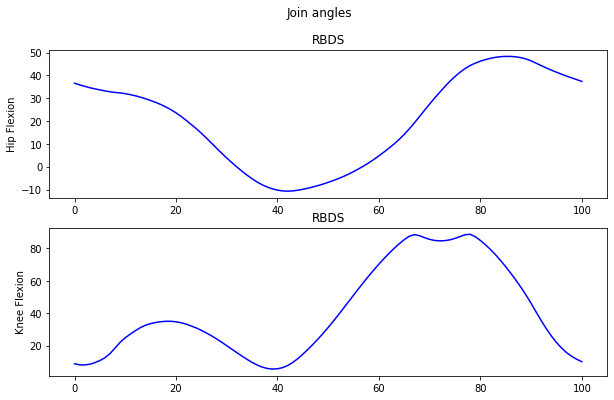

In [ ]:
fig, axs = plt.subplots(2, figsize=(10,6))
fig.suptitle('Join angles')
axs[0].plot(tn,ang_hipM_RBDS[:,0],'b')
axs[0].set_title('RBDS')
axs[0].set_ylabel('Hip Flexion')
axs[1].plot(tn,ang_kneeM_RBDS[:,0],'b')
axs[1].set_title('RBDS')
axs[1].set_ylabel('Knee Flexion')
plt.show()

# References
* Fukuchi RK, Fukuchi CA, Duarte M. 2017. A public dataset of running biomechanics and the effects of running speed on lower extremity kinematics and kinetics. PeerJ 5:e3298 https://doi.org/10.7717/peerj.3298
* Ferber et al. (in preparation). WeTrac 3D gait data set.

# Commit changes and push them to GitHub repository

In [ ]:
!git status

In [ ]:
!git add .

The file will have its original line endings in your working directory


In [ ]:
!git config --global user.email "reginaldo.fukuchi@gmail.com"

In [ ]:
!git config --global user.name "regifukuchi"

In [ ]:
!git commit -m "Modified RIC_RBDS_calculate_angles.ipynb"

[main ee5dc61] Modified RIC_RBDS_calculate_angles.ipynb
 16 files changed, 1 insertion(+), 1 deletion(-)
 mode change 100755 => 100644 functions/detecta-0.0.5.dist-info/LICENSE
 mode change 100755 => 100644 functions/detecta-0.0.5.dist-info/METADATA
 mode change 100755 => 100644 functions/detecta-0.0.5.dist-info/WHEEL
 mode change 100755 => 100644 functions/detecta-0.0.5.dist-info/top_level.txt
 mode change 100755 => 100644 functions/detecta/__init__.py
 mode change 100755 => 100644 functions/detecta/detect_cusum.py
 mode change 100755 => 100644 functions/detecta/detect_onset.py
 mode change 100755 => 100644 functions/detecta/detect_peaks.py
 mode change 100755 => 100644 functions/detecta/detect_seq.py
 mode change 100755 => 100644 functions/tnorma-0.0.3.dist-info/LICENSE
 mode change 100755 => 100644 functions/tnorma-0.0.3.dist-info/METADATA
 mode change 100755 => 100644 functions/tnorma-0.0.3.dist-info/WHEEL
 mode change 100755 => 100644 functions/tnorma-0.0.3.dist-info/top_level.txt

In [ ]:
!git push

Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 2 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 26.45 KiB | 2.40 MiB/s, done.
Total 9 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/regifukuchi/UFABC_UofC_datasets
   311f36e..ee5dc61  main -> main
